# 이미지 어디까지 우려볼까?

### Augmentation 적용 (1) 데이터 불러오기

오늘 augmentation을 텐서플로우 모델 학습에 어떻게 적용할 수 있는지 공부하겠다. 지금까지 모델을 훈련시키기 전, 데이터를 전처리해 입력값으로 사용해 왔다. Augmentation도 이처럼 입력 이미지의 데이터를 변경해 주는 과정이므로 일반적인 이미지 데이터 전처리 방법과 활용방법이 동일하다. 먼저 필요한 라이브러리들을 불러와 준다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


학습 전에는 항상 GPU 환경을 확인해 보자.

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

그리고 사용할 데이터셋을 불러오자. 이번 시간에는 stanford_dogs 데이터셋을 사용해보도록 하자. stanford_dogs 데이터셋에는 120개의 견종의 이미지가 포함되어 있다. 총 20,580장의 이미지에서 12,000장은 학습셋, 나머지 8,580장은 평가용 데이터셋이다.

https://www.tensorflow.org/datasets/catalog/stanford_dogs

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

=3


다운로드한 데이터를 확인해보자.

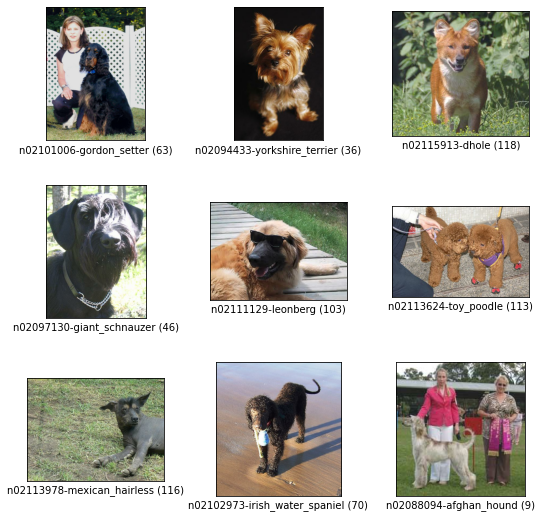

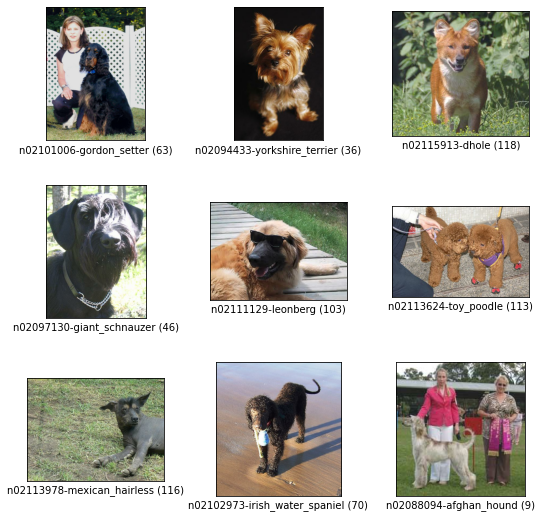

In [4]:
tfds.show_examples(ds_train, ds_info)

### Augmentation 적용 (2) Augmentation 적용하기

#### 텐서플로우 Random Augmentation API 사용하기

많은 augmentation 기법들이 있지만 그 중에서 텐서플로우 API로 바로 사용할 수 있는 방법들을 먼저 적용해 보겠다. 먼저 이미지셋에 대해서 랜덤한 확률로 바로 적용할 수 있는 augmentation 함수들은 아래와 같다.

random_brightness()

random_contrast()

random_crop()

random_flip_left_right()

random_flip_up_down()

random_hue()

random_jpeg_quality()

random_saturation()

그럼 Augmentation을 적용하기에 앞서 기본적인 전처리 함수를 만들어 주자.

In [5]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

print('=3')

=3


이미지를 변환하는 전처리 함수는 대략 다음과 같은 형태를 가지게 된다.

    def 전처리_함수(image, label):   # 변환할 이미지와 라벨
        # 이미지 변환 로직 적용
        new_image = 이미지_변환(image)
        return new_image, label

이렇게 되면 이미지 변환의 결과로 리턴 받은 이미지를 그다음 전처리 함수의 입력으로 연거푸 재사용할 수 있는 구조가 되어 편리하다. 위에서 만든 기본적인 전처리 함수도 위와 같은 구조를 가지고 있다. 이 함수는 입력받은 이미지를 0~1 사이의 float32로 normalize하고, (224, 224) 사이즈로 resize한다. 이 함수는 훈련용과 테스트용으로 사용될 모든 이미지에 적용될 것이다.

맨 위에서 언급한 random augmentation들 중에서 random_flip_left_right()과 random_brightness()를 활용해 보겠다. 'flip'의 경우 좌우 대칭을 해준다. 예컨대 이미지 분류 문제에서 개 이미지는 좌우를 대칭하더라도 문제가 생기지 않는다. 따라서 좌우대칭의 적용을 통해 데이터를 늘릴 수 있도록 한다. 여기서 상하 대칭은 테스트 데이터셋의 이미지를 생각해 볼 때 위아래가 뒤집한 사진이 없으므로 도움이 되지 않을 것이라 적용하지 않는다. 또 'brightness'를 조절하여 다양한 환경에서 얻어진 이미지에 대응할 수 있도록 하겠다.

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

print('=3')

=3


오늘의 Augmentation을 통해 원본 데이터셋에 다양한 형태의 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현한 메인 함수 apply_normalize_on_dataset()로 정의하겠다.

여기서는 apply_normalize_on_dataset()를 통해서 일반적인 전처리 과정, 즉 normalize, resize, augmentation과 shuffle을 적용하도록 하겠다. 이때 주의해야 할 점은 shuffle이나 augmentation은 테스트 데이터셋에는 적용하지 않아야 한다는 점이다.

여러 결과를 조합하기 위한 앙상블(ensemble) 방법 중 하나로 테스트 데이터셋에  augmentation을 적용하는 test-time augmentation이라는 방법이 있다. 이는 캐글 등의 경쟁 머신러닝에  많이 사용되지만, 지금은 개념만 알아두어도 된다.

아래 링크에서 test-time augmentation에 관한 설명을 참고하자.

https://hwiyong.tistory.com/215

코드에서는 이후에 수행할 비교실험을 위해서 with_aug 매개변수를 통해 augmentation의 적용여부를 결정할 수 있도록 하겠다.

https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map

In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


### Random Augmentation 직접 구현하기

위에서는 미리 구현된 random augmentation을 적용하도록 augment() 함수를 작성했다. 이번에는 tf.image의 다양한 함수들을 이용해서 직접 다양한 augmentation 기법을 랜덤하게 적용하는 augment2() 함수를 작성해보자.

In [8]:
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

### Augmentation 적용 (3) 비교실험 하기

이제 비교 실험을 해보도록 하겠다. 우리가 비교해야 하는 것은 augmentation을 적용한 데이터를 학습시킨 모델과 적용하지 않은 데이터를 학습시킨 모델의 성능이다. 새로운 augmentation이 떠오를 때 새로운 함수로 agumentation한 데이터와 아닌 데이터를 학습시켜서 어떤 효과가 있는지 실험을 통해 알아볼 수 있다.

아래 코드는 텐서플로우 케라스의 ResNet50 중 imagenet으로 훈련된 모델을 불러온다. include_top은 마지막 fully connected layer를 포함할지 여부이다. 해당 레이어를 포함하지 않고 생성하면 특성 추출기(feature extractor) 부분만 불러와 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있다. 이렇게 하는 이유는 이미지넷(ImageNet)과 우리의 테스트 셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수) 또한 다르기 때문이다.

In [9]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


Augmentation을 적용한 데이터셋으로 학습시킬 ResNet을 하나 더 만들어준다.

In [10]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


텐서플로우 데이터셋에서 불러온 데이터에 하나는 apply_normalize_on_dataset()에서 with_aug를 False로 주어 augmentation이 적용되지 않도록 하고, 다른 하나는 True로 주어 augmentation이 적용되도록 한다.

In [11]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


이제 두개 모델에 각각 agumentation이 적용된 데이터 셋과 적용되지 않은 데이터셋을 학습시키고, 검증을 진행한다.

In [12]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 3

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 187s 225ms/step - loss: 2.2156 - accuracy: 0.4480 - val_loss: 3.6979 - val_accuracy: 0.1687
Epoch 2/3
750/750 [==============================] - 168s 224ms/step - loss: 0.7072 - accuracy: 0.8078 - val_loss: 1.0971 - val_accuracy: 0.6809
Epoch 3/3
750/750 [==============================] - 168s 224ms/step - loss: 0.2128 - accuracy: 0.9571 - val_loss: 0.9408 - val_accuracy: 0.7267


In [13]:
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/3
750/750 [==============================] - 180s 223ms/step - loss: 2.2630 - accuracy: 0.4382 - val_loss: 3.0955 - val_accuracy: 0.2498
Epoch 2/3
750/750 [==============================] - 165s 221ms/step - loss: 0.9034 - accuracy: 0.7433 - val_loss: 1.3870 - val_accuracy: 0.6009
Epoch 3/3
750/750 [==============================] - 178s 237ms/step - loss: 0.4868 - accuracy: 0.8692 - val_loss: 1.1670 - val_accuracy: 0.6634


훈련 과정을 시각화 해보자.

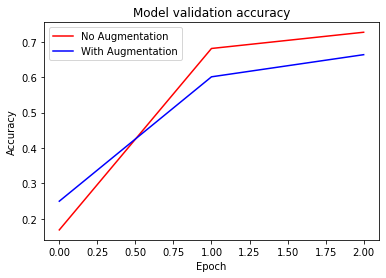

In [14]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

조금 더 확대해 보자.

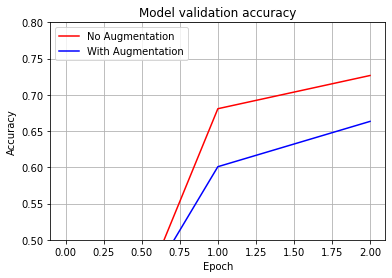

In [15]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

참고로, EPOCH+=20으로 수행해 본 두 모델의 훈련 과정 시각화한 내용은 아래 그림과 같다. Augmentation 적용한 경우가 보다 천천히 학습되지만, EPOCH 10을 전후해서 aug_resnet50의 accuracy가 더 높게 형성되는 것을 확인할 수 있다.

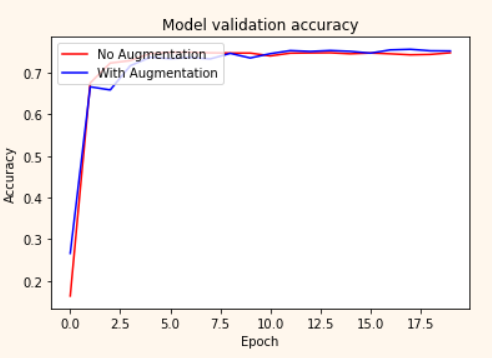

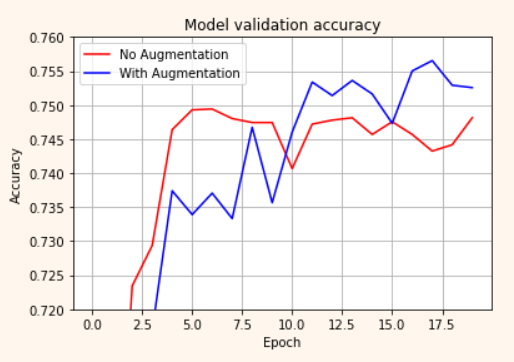

### 심화 기법 (1) Cutmix Augmentation


지금부터 조금 더 복잡한 augmentation 방법을 알아보겠다.

첫번째는 CutMix augmentation이다.

https://arxiv.org/pdf/1905.04899.pdf

https://www.kaggle.com/code/cdeotte/cutmix-and-mixup-on-gpu-tpu/notebook

CutMix는 네이버 클로바(CLOVA)에서 발표한 CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features에서 제안된 방법이다. 이름인 CutMix를 보고 유추할 수 있듯 이미지 데이터를 자르고 섞는다고 생각할 수 있다.

아래 표에서 ResNet-50 컬럼은 우리가 일반적으로 사용해왔던 방식을 나타낸다. Mixup은 특정 비율로 픽셀별 값을 섞는 방식이고, Cutout은 이미지를 잘라내는 방식이다. CutMix는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법이다.
차에 비유하면 블렌딩 같은 방법이다.


두번째 링크인 Chris Deotte's CutMix and MixUp on GPU/TPU에서는 캐글 그랜드마스터인 Chris Deotte가 구현한 CutMix와 MixUp을 확인 할 수 있다. 남은 스텝에서 CutMix와 MixUp을 구현하면서 참고하도록 하자. 참고로 캐글에서 지금 참가하고 있는 대회와 비슷한 태스크의 경진대회가 있는 경우, 다른 사람들이 적용한 방법들을 찾아보는 것도 인사이트를 얻는 데 좋다.

CutMix는 이미지를 섞는 부분과 섞은 이미지에 맞추어 라벨을 섞는 부분을 포함한다. 이제 한 부분씩 구현해 보겠다.

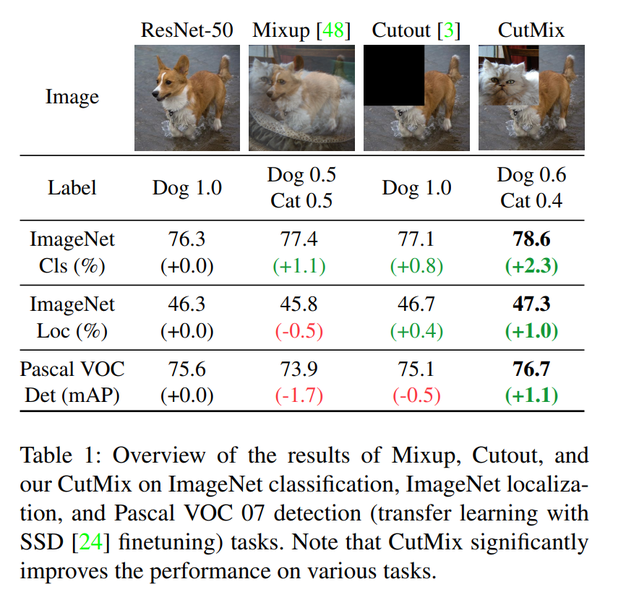

#### 1. 이미지 섞기

가장 먼저 두개의 이미지를 섞어주는 것부터 생각해 보자. 배치 내의 이미지를 두개 골라서 섞어준다. 이때 이미지에서 잘라서 섞어주는 영역을 바운딩 박스(bounding box)라고 부른다.

예시를 위해 훈련데이터셋에서 이미지 2개를 가져와 보겠다.

아래 코드 블록에 바운딩 박스의 위치를 랜덤하게 뽑고 이를 잘라내서 두개의 이미지를 섞어주는 함수를 만들어 보자. 이미지를 텐서로 만들어 텐서플로우 연산을 사용해보자. 이때 이미지는 tfds에서 한장을 뽑아서 사용해보자.

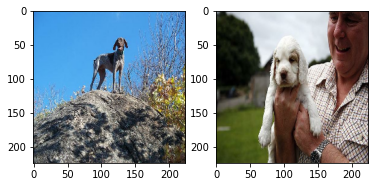

In [16]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

두개의 이미지를 얻었다.

이 중 첫번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두번째 이미지 b가 있을 때, a에 삽입될 영역의 박스의 위치를 결정하는 함수를 먼저 구현해 보자.

이번 노드에서는 이미지 a, b가 모두 (224, 224)로 resize되어 두 이미지의 width, height가 같은 경우로 가정할 수 있지만, CutMix 공식 repo에서는 width, height가 다르더라도 가변적으로 적용할 수 있도록 구현되어 있기 때문에, 임의의 이미지 사이즈에 대해서도 유연하게 대응 가능하도록 구현해 보겠다.

In [17]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(116, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(97, shape=(), dtype=int32)


바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현해 보자.

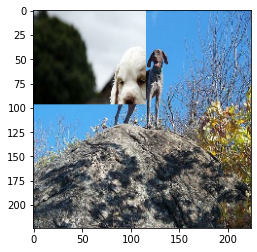

In [18]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

#### 2.라벨 섞기

이미지를 섞었다면 라벨도 이에 맞게 섞어주어야 한다. 그림에서 볼 수 있듯, 우리가 강아지와 고양이의 이미지를 섞었다면 라벨 또한 적절한 비율로 섞어야 한다.

CutMix에서는 면적에 비례해서 라벨을 섞어준다. 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두가지 라벨의 비율로 더해준다. 예를 들어 A 클래스를 가진 원래 이미지 image_a와 B 클래스를 가진 이미지 image_b를 섞을 때 image_a를 0.4만큼 섞었을 경우, 0.4만큼의 클래스 A, 0.6만큼의 클래스 B를 가지도록 해준다. 이때 라벨 벡터는 보통 클래스를 표시하듯 클래스 1개만 1의 값을 가지는 원-핫 인코딩이 아니라 A와 B 클래스에 해당하는 인덱스에 각각 0.4, 0.6을 배분하는 방식을 사용한다.

위에서 석인 이미지 두 가지에 대하여 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수를 구현해 보자.

In [19]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.7757493 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.22425064, 0.        , 0.        , 0.        , 0.        ,
       0.     

이제 거의다 준비되었다.

위에서 구현한 두함수 mix_2_images()와 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수를 구현해 보자.

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

### 심화 기법 (2) Mixup Augmentation

Mixup은 앞에서 보여드린 CutMix 보다 간단하게 이미지와 라벨을 섞어준다. 아래 참고자료는 앞에서 본 CutMix 비교표에서 'Mixup'이라는 방법이 제안된 논문이다. 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 CutMix보다 구현이 간단하다고 볼 수 있다. 아래에서 직접 Mixup 함수를 구현해 보자.

https://arxiv.org/abs/1710.09412

두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 된다.

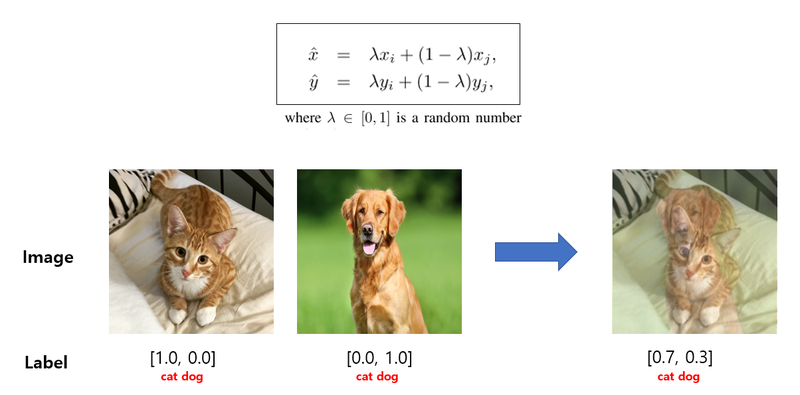

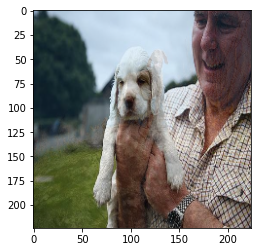

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.17010665
 0.         0.         0.         0.         0.         0.82989335
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.    

In [20]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

그러면 위에서 구현한 함수를 활용하여 배치 단위의 mixup() 함수를 구현해 보자.

In [21]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3
